In [1]:
import torch
import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from torchvision import models, transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision
from functools import partial
import keras
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [2]:
PATH_TO_RAVDESS = Path.cwd()/"ravdess"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS/"train"
bs_train = 1440

In [3]:
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

In [4]:
ravdess_train = PrecomputedRavdess(PATH_RAVDESS_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
)

In [5]:
ravdess_train_loader = torch.utils.data.DataLoader(ravdess_train,bs_train, shuffle=True)
spectogram = torch.utils.data.DataLoader(ravdess_train,32,shuffle=True )

Validationslabel: tensor([5, 4, 3, 5, 7, 6, 3, 5, 7, 6, 6, 6, 8, 2, 4, 7, 7, 8, 2, 4, 2, 5, 4, 4,
        5, 8, 7, 2, 2, 2, 2, 4])


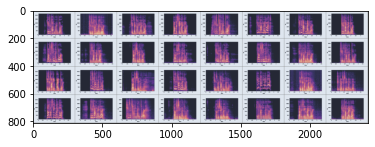

In [6]:
images, labels = next(iter(ravdess_train_loader))  
img, label = next(iter(spectogram))  
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
print('Validationslabel:',label)
imshow(torchvision.utils.make_grid(img)/3)

In [7]:
labels.shape

torch.Size([1161])

In [8]:
# Modelskonfiguration
batch_size = 32
img_width, img_height, img_num_channels = 3,200,300
loss_function = sparse_categorical_crossentropy
no_classes = 9
optimizer = Adam()
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [9]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [10]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=3, strides=1,
                        input_shape= input_shape ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 8
#for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: 
for filters in [64] * 1 + [128] * 1 + [256] * 2: 
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(no_classes, activation="softmax"))

In [11]:
images = (tf.cast(images, tf.float32) / 255).numpy()
labels = labels.numpy()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 200, 64)        172800    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 200, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 3, 200, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 100, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 1, 50, 64)         78592     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 1, 25, 128)        230912    
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 1, 13, 256)        9

In [13]:
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=loss_function,
              optimizer=optimizer,  metrics=['accuracy'])

In [14]:
history = model.fit(images, labels,
            batch_size=batch_size,
            epochs=100,        
            verbose=verbosity,
            validation_split = 0.2) 

Epoch 1/100
29/29 [==============================] - 14s 394ms/step - loss: 2.2494 - accuracy: 0.1949 - val_loss: 2.1417 - val_accuracy: 0.1502
Epoch 2/100
29/29 [==============================] - 10s 344ms/step - loss: 1.5923 - accuracy: 0.3914 - val_loss: 2.1602 - val_accuracy: 0.1545
Epoch 3/100
29/29 [==============================] - 10s 354ms/step - loss: 1.2899 - accuracy: 0.5295 - val_loss: 2.3106 - val_accuracy: 0.1502
Epoch 4/100
29/29 [==============================] - 10s 359ms/step - loss: 1.1152 - accuracy: 0.5944 - val_loss: 3.1039 - val_accuracy: 0.1502
Epoch 5/100
29/29 [==============================] - 11s 382ms/step - loss: 0.9162 - accuracy: 0.6667 - val_loss: 2.7258 - val_accuracy: 0.1502
Epoch 6/100
29/29 [==============================] - 10s 348ms/step - loss: 0.8383 - accuracy: 0.6794 - val_loss: 3.1784 - val_accuracy: 0.1631
Epoch 7/100
29/29 [==============================] - 10s 345ms/step - loss: 0.6149 - accuracy: 0.7998 - val_loss: 5.6535 - val_accuracy:

29/29 [==============================] - 10s 347ms/step - loss: 3.8901e-04 - accuracy: 1.0000 - val_loss: 1.5466 - val_accuracy: 0.6609
Epoch 58/100
29/29 [==============================] - 10s 350ms/step - loss: 3.3203e-04 - accuracy: 1.0000 - val_loss: 1.5418 - val_accuracy: 0.6652
Epoch 59/100
29/29 [==============================] - 10s 343ms/step - loss: 3.8442e-04 - accuracy: 1.0000 - val_loss: 1.5336 - val_accuracy: 0.6738
Epoch 60/100
29/29 [==============================] - 10s 343ms/step - loss: 5.1847e-04 - accuracy: 1.0000 - val_loss: 1.5765 - val_accuracy: 0.6867
Epoch 61/100
29/29 [==============================] - 10s 345ms/step - loss: 2.4944e-04 - accuracy: 1.0000 - val_loss: 1.5605 - val_accuracy: 0.6824
Epoch 62/100
29/29 [==============================] - 10s 347ms/step - loss: 3.8580e-04 - accuracy: 1.0000 - val_loss: 1.5422 - val_accuracy: 0.6910
Epoch 63/100
29/29 [==============================] - 10s 343ms/step - loss: 2.9043e-04 - accuracy: 1.0000 - val_loss: 

In [15]:
loss, acc = model.evaluate(images, labels)
print("Train, accuracy: {:5.2f}%".format(100*acc))

37/37 [==============================] - 2s 47ms/step - loss: 0.3211 - accuracy: 0.9345
Train, accuracy: 93.45%


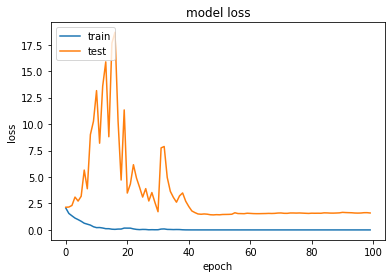

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

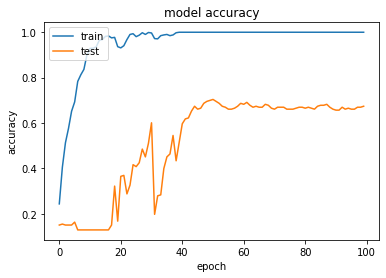

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

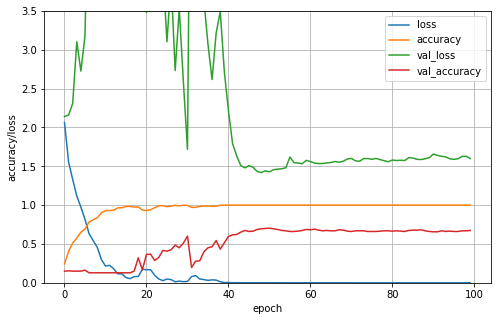

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.gca().set_ylim(0, 3.5)
plt.show()

## Save Modell

In [21]:
model.save_weights("kr_model.h5")

## Test Modell

In [43]:
PATH_RAVDESS_TEST = PATH_TO_RAVDESS/"test"
bs_test = 1440

In [56]:
ravdess_test = PrecomputedRavdess(PATH_RAVDESS_TEST,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
)
ravdess_test_loader = torch.utils.data.DataLoader(ravdess_test,bs_test, shuffle=True)
images_test, labels_test = next(iter(ravdess_test_loader))  

In [57]:
labels_test.shape

torch.Size([279])

In [58]:
images_test = (tf.cast(images_test, tf.float32) / 255).numpy()
labels_test = labels_test.numpy()

In [38]:
model_test = keras.models.Sequential()
model_test.add(DefaultConv2D(64, kernel_size=3, strides=1,
                        input_shape= input_shape ))
model_test.add(keras.layers.BatchNormalization())
model_test.add(keras.layers.Activation("relu"))
model_test.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 8
for filters in [64] * 1 + [128] * 1 + [256] * 2: 
    strides = 1 if filters == prev_filters else 2
    model_test.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model_test.add(keras.layers.GlobalAvgPool2D())
model_test.add(keras.layers.Flatten())
model_test.add(keras.layers.Dense(no_classes, activation="softmax"))

In [40]:
model_test.load_weights('kr_model.h5')

In [59]:
optimizer = keras.optimizers.Nadam(lr=1e-3)
model_test.compile(loss=loss_function,
              optimizer=optimizer,  metrics=['accuracy'])

In [60]:
loss, acc = model.evaluate(images_test, labels_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

9/9 [==============================] - 0s 45ms/step - loss: 1.6093 - accuracy: 0.6953
Restored model, accuracy: 69.53%


In [61]:
model_test.save_weights("kr_model_prod.h5")